In [128]:
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt  
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as sp
from scipy.stats import norm, skew 


In [129]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
reall_train = pd.read_csv('./For_Kaggle/train.csv')
reall_test = pd.read_csv('./For_Kaggle/test.csv')

In [86]:
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

reall_train.drop("Id", axis = 1, inplace = True)
reall_test.drop("Id", axis = 1, inplace = True)


ValueError: labels ['Id'] not contained in axis

array([60, 'RL', 65.0, 8450, 'Pave', nan, 'Reg', 'Lvl', 'AllPub', 'Inside',
       'Gtl', 'CollgCr', 'Norm', 'Norm', '1Fam', '2Story', 7, 5, 2003,
       2003, 'Gable', 'CompShg', 'VinylSd', 'VinylSd', 'BrkFace', 196.0,
       'Gd', 'TA', 'PConc', 'Gd', 'TA', 'No', 'GLQ', 706, 'Unf', 0, 150,
       856, 'GasA', 'Ex', 'Y', 'SBrkr', 856, 854, 0, 1710, 1, 0, 2, 1, 3,
       1, 'Gd', 8, 'Typ', 0, nan, 'Attchd', 2003.0, 'RFn', 2, 548, 'TA',
       'TA', 'Y', 0, 61, 0, 0, 0, 0, nan, nan, nan, 0, 2, 2008, 'WD',
       'Normal'], dtype=object)

In [119]:
indexes = []
test_idx = []
for i in range(len(test)):
    for j in range(len(reall_train)):
        if list(test.iloc[i, :].values) == list(reall_train.iloc[j, :].values[:-1]):
            test_idx.append({i: reall_train.iloc[j, :].values[-1]})
            indexes.append(j)
indexes
            

[9,
 17,
 19,
 25,
 26,
 30,
 34,
 38,
 44,
 46,
 47,
 49,
 52,
 54,
 57,
 59,
 61,
 63,
 73,
 74,
 75,
 77,
 85,
 87,
 103,
 110,
 114,
 129,
 132,
 138,
 139,
 143,
 146,
 161,
 171,
 181,
 187,
 188,
 192,
 216,
 222,
 227,
 239,
 240,
 247,
 248,
 254,
 259,
 264,
 265,
 270,
 272,
 274,
 275,
 278,
 283,
 285,
 290,
 295,
 303,
 304,
 315,
 320,
 343,
 348,
 349,
 355,
 357,
 362,
 367,
 377,
 379,
 381,
 383,
 389,
 394,
 398,
 400,
 407,
 414,
 415,
 419,
 420,
 423,
 425,
 428,
 437,
 439,
 449,
 460,
 462,
 467,
 475,
 477,
 482,
 483,
 485,
 489,
 493,
 505,
 506,
 508,
 509,
 510,
 511,
 519,
 521,
 526,
 532,
 540,
 542,
 552,
 553,
 558,
 570,
 572,
 578,
 583,
 584,
 585,
 589,
 608,
 609,
 617,
 619,
 627,
 634,
 637,
 651,
 653,
 656,
 657,
 658,
 659,
 663,
 671,
 680,
 692,
 696,
 699,
 701,
 703,
 704,
 713,
 723,
 725,
 730,
 736,
 739,
 740,
 741,
 742,
 744,
 747,
 748,
 762,
 765,
 768,
 769,
 773,
 775,
 776,
 778,
 786,
 790,
 798,
 799,
 802,
 803,
 805,
 806,

In [120]:
test_idx

[{0: 118000},
 {3: 90000},
 {4: 139000},
 {5: 256300},
 {6: 134800},
 {7: 40000},
 {8: 277500},
 {9: 109000},
 {11: 141000},
 {12: 239686},
 {13: 249700},
 {14: 127000},
 {15: 110000},
 {16: 130000},
 {17: 196500},
 {18: 124900},
 {19: 101000},
 {20: 140000},
 {23: 144900},
 {24: 107400},
 {25: 91000},
 {26: 127000},
 {28: 260000},
 {29: 164500},
 {32: 198900},
 {35: 136900},
 {37: 259500},
 {41: 150000},
 {42: 150750},
 {44: 230000},
 {45: 231500},
 {46: 204000},
 {47: 105000},
 {49: 412500},
 {51: 215000},
 {53: 200100},
 {55: 135000},
 {56: 153337},
 {57: 192000},
 {59: 210000},
 {61: 179900},
 {62: 106000},
 {63: 113000},
 {64: 262500},
 {67: 140000},
 {68: 180000},
 {70: 145000},
 {71: 97000},
 {72: 73000},
 {73: 175500},
 {74: 266000},
 {75: 290000},
 {76: 124500},
 {77: 205000},
 {78: 415298},
 {79: 244600},
 {80: 164700},
 {81: 233230},
 {83: 142500},
 {84: 149900},
 {85: 295000},
 {88: 188500},
 {89: 342643},
 {91: 266000},
 {94: 154000},
 {95: 437154},
 {96: 177500},
 {98: 13

In [183]:
reall_train[np.array([2])]

,MSZoning
0,RL
1,RL
2,RL
3,RL
4,RL
5,RL
6,RL
7,RL
8,RM
9,RL


In [116]:
reall_train.index

RangeIndex(start=0, stop=1460, step=1)

In [130]:

print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))


train_ID = train['Id']
test_ID = test['Id']


train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)


print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1030, 81) 
The test data size before dropping Id feature is : (430, 80) 

The train data size after dropping Id feature is : (1030, 80) 
The test data size after dropping Id feature is : (430, 79) 


# 데이터 전처리


- outlier 제거

- 지나치게 큰 이상치를 제거함으로써 안전한 모델을 만들수 있다 다른 이상치가 있을 수 있으나, 테스트 데이터에도 이상치가 있을 수 있으므로, 이상치를 모두 없애기보다는, 일부는 남겨서 더 강건한 모델을 구축할 수 있다. 

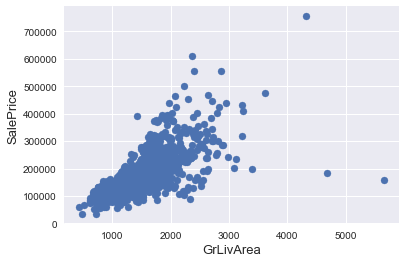

In [131]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

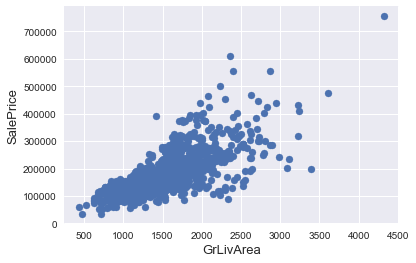

In [132]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)


fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

# 목적 함수
- SalePrice
- regression에서 데이터들은 skewed 되지않고 정규분포에 가까울수록 좋은 결과가 나오므로
- QQ plot을 통해 정규분포인지 확인한다
- 아래에서는 skewed data이므로 정규분포를 따르게 하기위해 여기서는 log-transformation을 해주었다.

C:\Users\POWER USER\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j



 mu = 181547.39 and sigma = 78105.45



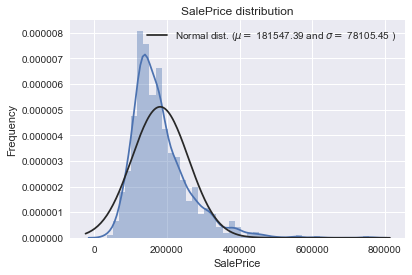

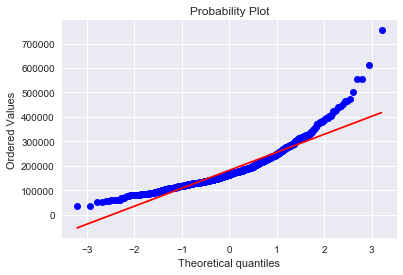

In [133]:
sns.distplot(train['SalePrice'] , fit=norm);

(mu, sigma) = sp.norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')


fig = plt.figure()
res = sp.probplot(train['SalePrice'], plot=plt)
plt.show()

C:\Users\POWER USER\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j



 mu = 12.03 and sigma = 0.40



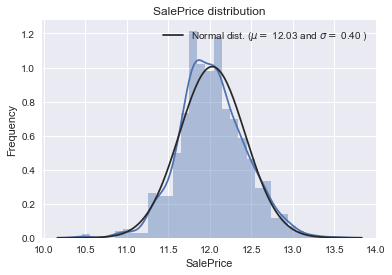

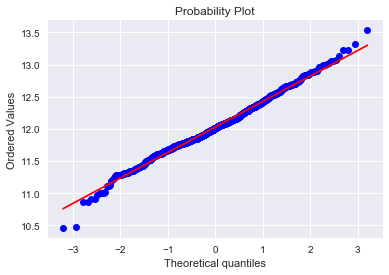

In [134]:

train["SalePrice"] = np.log(train["SalePrice"])


sns.distplot(train['SalePrice'] , fit=norm);

(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))


plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')


fig = plt.figure()
res = sp.probplot(train['SalePrice'], plot=plt)
plt.show()

In [135]:
ntrain = train.shape[0]
ntest = test.shape[0]

y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (1458, 79)


In [136]:
all_data.count()

1stFlrSF         1458
2ndFlrSF         1458
3SsnPorch        1458
Alley              91
BedroomAbvGr     1458
BldgType         1458
BsmtCond         1421
BsmtExposure     1420
BsmtFinSF1       1458
BsmtFinSF2       1458
BsmtFinType1     1421
BsmtFinType2     1420
BsmtFullBath     1458
BsmtHalfBath     1458
BsmtQual         1421
BsmtUnfSF        1458
CentralAir       1458
Condition1       1458
Condition2       1458
Electrical       1457
EnclosedPorch    1458
ExterCond        1458
ExterQual        1458
Exterior1st      1458
Exterior2nd      1458
Fence             281
FireplaceQu       768
Fireplaces       1458
Foundation       1458
FullBath         1458
                 ... 
LotFrontage      1199
LotShape         1458
LowQualFinSF     1458
MSSubClass       1458
MSZoning         1458
MasVnrArea       1450
MasVnrType       1450
MiscFeature        54
MiscVal          1458
MoSold           1458
Neighborhood     1458
OpenPorchSF      1458
OverallCond      1458
OverallQual      1458
PavedDrive

# Missing Data
- 데이터셋에는 NA로 된 데이터가 많았다. 
- 각 feature별로 isnull()함수를 통해 비어있는 칸을 구하고 그 비율을 구한다.  


In [137]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na[all_data_na > 0].sort_values(ascending = False)
all_data_na

PoolQC          99.588477
MiscFeature     96.296296
Alley           93.758573
Fence           80.727023
FireplaceQu     47.325103
LotFrontage     17.764060
GarageYrBlt      5.555556
GarageType       5.555556
GarageQual       5.555556
GarageFinish     5.555556
GarageCond       5.555556
BsmtFinType2     2.606310
BsmtExposure     2.606310
BsmtQual         2.537723
BsmtFinType1     2.537723
BsmtCond         2.537723
MasVnrArea       0.548697
MasVnrType       0.548697
Electrical       0.068587
dtype: float64

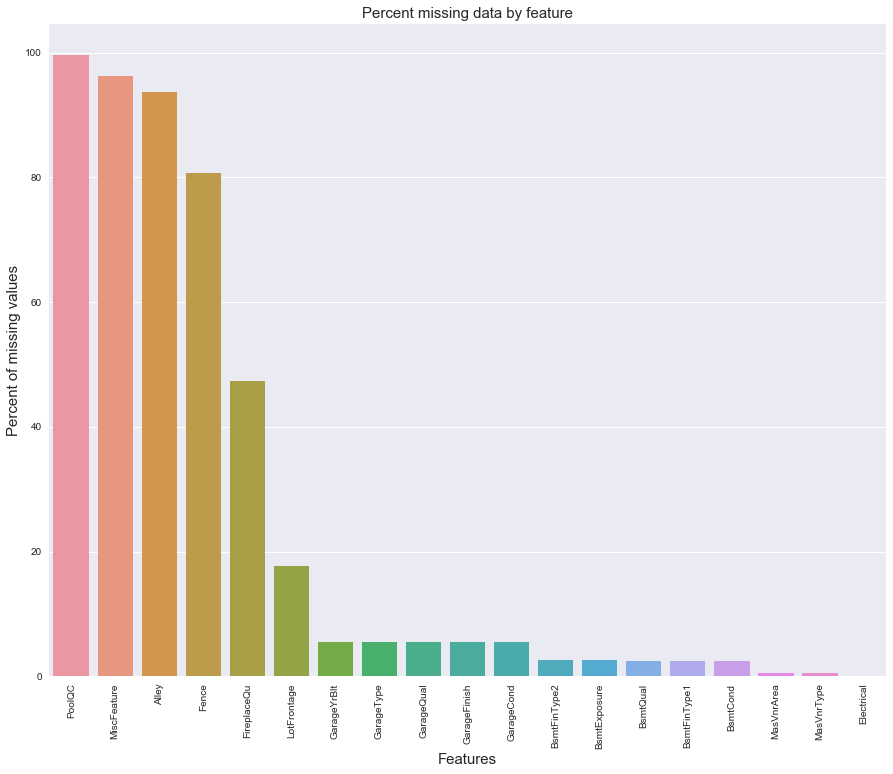

In [138]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

# 상관분석

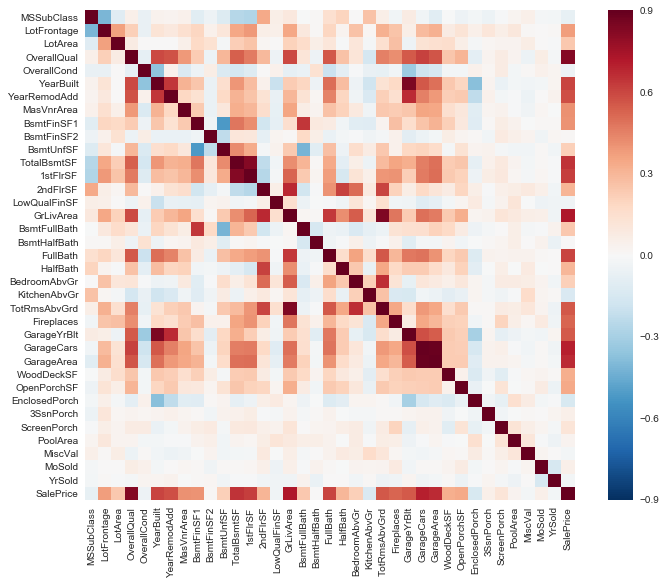

In [139]:

corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [140]:
all_data["BsmtFinType2"]

0       Unf
1       Unf
2       Unf
3       Unf
4       Unf
5       Unf
6       Unf
7       BLQ
8       Unf
9       Unf
10      Unf
11      Unf
12      Unf
13      Unf
14      Unf
15      Unf
16      Unf
17      Unf
18      Unf
19      ALQ
20      Unf
21      Unf
22      Unf
23      Unf
24      Unf
25      Unf
26      Unf
27      Unf
28      Unf
29      NaN
       ... 
1428    Unf
1429    Unf
1430    Unf
1431    Unf
1432    Unf
1433    Unf
1434    Unf
1435    Unf
1436    Unf
1437    Unf
1438    Unf
1439    Unf
1440    Unf
1441    Unf
1442    Unf
1443    Unf
1444    Unf
1445    Unf
1446    Unf
1447    Unf
1448    Unf
1449    Unf
1450    Unf
1451    Rec
1452    Unf
1453    Unf
1454    Unf
1455    Rec
1456    Unf
1457    LwQ
Name: BsmtFinType2, dtype: object

# Missing data 채우기

- 데이터가 수치형 데이터(numeric data)와 범주형 데이터(categorical data)가 섞여있으므로 따로 채운다.
- 이를 분석하기 위해서 각 feature들의 의미를 정확히 분석할 필요가 있다.

- 다음은 missing data가 있는 feature들을 모아 Kaggle에서 나온 feature들의 설명을 덧붙인 것이다.

- PoolQC         : Pool quality (풀장의 질, Nan이면 없는것 : /범주형)
- MiscFeature    : Miscellaneous feature not covered in other categories(기타: None /??)
- Alley          : Type of alley access (근접한 골목 종류 Nan이면 없는것 : /범주형
- Fence          : Fence quality (울타리의 질, Nan이면 없는것 :/ 범주형)
- FireplaceQu    : Fireplace quality (난로의 질: Nan이면 없는것 :/ 범주형)
- LotFrontage    : Linear feet of street connected to property (집의 너비 Nan은 임의로 같은 이웃을 가진 index들의 평균값으로 설정 : /수치형)
- GarageYrBlt    : Year garage was built (차고 지어진 년수 Nan이면 없는것 : 0 /수치형)
- GarageType     : Garage location (차고 종류 Nan이면 없는것 : None /범주형)
- GarageQual     : Garage quality  (차고 질 Nan이면 없는것 : None /범주형)
- GarageFinish   : Interior finish of the garage (차고 마감 Nan이면 없는것 : None /범주형)
- GarageCond     : General condition of the basement (차고 상태 Nan이면 없는것 : None/ 범주형)
- BsmtFinType2   : Quality of second finished area (if present) (지하실 없으면 Nan : None/범주형)
- BsmtExposure   : Walkout or garden level basement walls (지하실 없으면 Nan : None/범주형)
- BsmtQual       : Height of the basement (지하실의 높이 지하실 없으면 Nan : None/범주형)
- BsmtFinType1   : Quality of basement finished area (지하실 없으면 Nan: None/범주형)
- BsmtCond       : General condition of the basement (지하실 상태 지하실 없으면 Nan:None /범주형)
- MasVnrArea     : Masonry veneer area in square feet (벽돌 지역 없으면 Nan: 0/수치형
- MasVnrType     : Masonry veneer type (벽돌 지역 없으면 Nan: 0/수치형)
- Electrical     : Electrical system (전기 없으면 Nan:none/범주형)

## None으로 바꿔야할 Features
- 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageQual', 'GarageFinish', 'GarageCond','BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtFinType1', 'BsmtCond', 'MasVnrType', 'Electrical'

In [141]:
to_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
           'GarageType', 'GarageQual', 'GarageFinish', 'GarageCond',
           'BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtFinType1',
           'BsmtCond', 'MasVnrType', 'Electrical']
all_data[to_none] = all_data[to_none].fillna("None")

## 0으로 바꿔야할 Features
- 'MasVnrArea',' GarageYrBlt'

- LotFrontage는 누락된 것으로 보이므로 이웃들의 평균값으로 가정한다. 

In [142]:
to_zero = ['MasVnrArea','GarageYrBlt']
all_data[to_zero] = all_data[to_zero].fillna(0)


In [143]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.mean()))

In [144]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio


## 수치이지만 실제로는 범주형 데이터인 것들
- 건물 클래스는 범주형이다.(MSSubClass)
- 전체적인 건물상태 -> 범주형 (OverallCond)
- 팔린 년도, 월은 범주형 (참고: 시계열 데이터는 범주형도 수치형도 아니고, 분석 목적에 따라 변할 수 있다. 예를 들어 시간에 따라 점차적으로 수치가 변화한다면 수치데이터, 이와같이 특정한 년, 월을 기준으로 한다면 범주형 데이터로 분석한다. (YrSold, MoSold)

In [145]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)



all_data['OverallCond'] = all_data['OverallCond'].astype(str)



all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [146]:
len(all_data.columns)

79

In [147]:
list1 = []
for i in range(len(all_data.columns)):
    if type(all_data.iloc[1, :][i]) == str:
        list1.append(True)
    else:
        list1.append(False)
all_data.columns[list1]

Index(['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd',
       'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC',
       'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig',
       'LotShape', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature',
       'MoSold', 'Neighborhood', 'OverallCond', 'PavedDrive', 'PoolQC',
       'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street',
       'Utilities', 'YrSold'],
      dtype='object')

In [148]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
print(len(numeric_feats))

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness

32

Skew in numerical features: 



,Skew
MiscVal,24.434913
PoolArea,15.932532
LotArea,12.560986
3SsnPorch,10.286510
LowQualFinSF,8.995688
KitchenAbvGr,4.480268
BsmtFinSF2,4.247550
ScreenPorch,4.114690
BsmtHalfBath,4.095895
EnclosedPorch,3.083987


In [149]:
skewness = skewness[abs(skewness) > 0.75].dropna()

transfor = skewness.index

all_data[transfor] = sp.boxcox(1+all_data[transfor], 0.3)


In [150]:
all_data.groupby(all_data.columns, axis=1)

In [151]:
all_data = pd.get_dummies(all_data)

In [152]:
train = all_data[:ntrain]
test = all_data[ntrain:]
print(train.shape)
print(test.shape)


(1028, 339)
(430, 339)


# OLS 로 해보자

In [153]:
dfX0 = train
const = pd.DataFrame(np.array([1.0 for _ in range(len(train))]), columns = ['const'])
dfX = pd.concat([const, dfX0], axis = 1)

dfy = pd.DataFrame(y_train, columns = ['SalePrice'])

result = sm.OLS(dfy, dfX).fit()
print(result.summary())

C:\Users\POWER USER\Anaconda3\lib\site-packages\statsmodels\base\model.py:978: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\POWER USER\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\POWER USER\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\POWER USER\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     67.42
Date:                Mon, 23 Oct 2017   Prob (F-statistic):               0.00
Time:                        11:14:40   Log-Likelihood:                 1144.6
No. Observations:                1028   AIC:                            -1749.
Df Residuals:                     758   BIC:                            -416.6
Df Model:                         269                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
const                     0.27

In [154]:
result.pvalues

const                    4.587385e-02
1stFlrSF                 1.158070e-01
2ndFlrSF                 7.108712e-01
3SsnPorch                1.834917e-01
BedroomAbvGr             3.380589e-01
BsmtFinSF1               4.145513e-01
BsmtFinSF2               9.398674e-01
BsmtFullBath             9.287256e-02
BsmtHalfBath             3.012987e-01
BsmtUnfSF                1.491016e-02
EnclosedPorch            4.247565e-01
Fireplaces               2.712439e-01
FullBath                 1.107301e-01
GarageArea               3.061281e-01
GarageCars               5.472934e-02
GarageYrBlt              5.801487e-01
GrLivArea                1.860125e-08
HalfBath                 1.705291e-01
KitchenAbvGr             2.692300e-01
LotArea                  1.241145e-14
LotFrontage              8.948580e-01
LowQualFinSF             2.322965e-01
MasVnrArea               4.020081e-01
MiscVal                  3.551726e-02
OpenPorchSF              5.609494e-01
OverallQual              6.839267e-12
PoolArea    

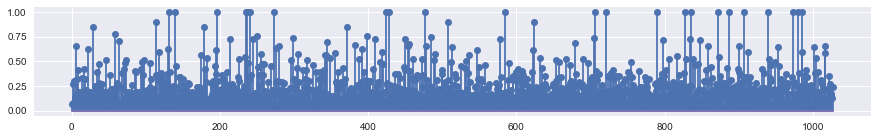

hat.sum() = 270.0


In [155]:
influence = result.get_influence()
hat = influence.hat_matrix_diag

plt.figure(figsize=(15, 2))
plt.stem(hat)
plt.show()
print("hat.sum() =", hat.sum())

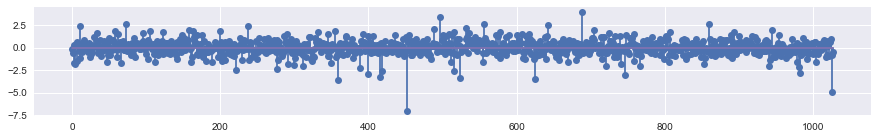

In [156]:
plt.figure(figsize=(15, 2))
plt.stem(result.resid_pearson)
plt.show()

C:\Users\POWER USER\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:309: RuntimeWarning: invalid value encountered in sqrt
  return  self.results.resid / sigma / np.sqrt(1 - hii)
C:\Users\POWER USER\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\POWER USER\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\POWER USER\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\POWER USER\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in greater


[   3    7   29   34   58   73   96  105  114  130  158  179  196  235  238
  250  259  273  275  276  296  299  312  316  325  344  349  355  359  372
  382  399  400  406  415  418  428  436  448  450  452  454  455  473  476
  478  485  489  496  500  507  512  513  515  524  532  536  578  590  608
  623  624  625  657  679  680  688  705  720  724  746  755  767  790  802
  806  827  829  853  859  872  900  901  941  942  944  949  973  981  983
 1017 1025]


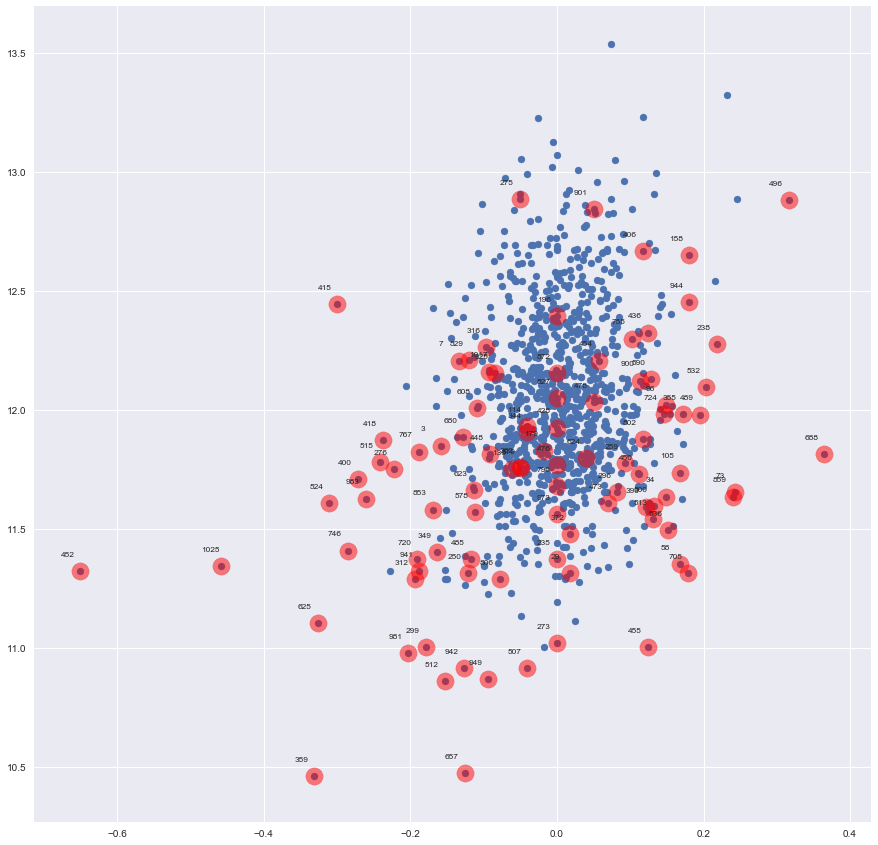

In [157]:
from statsmodels.graphics import utils

cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (len(y_train) - 2)
idx = np.where(cooks_d2 > fox_cr)[0]
print(idx)
plt.figure(figsize=(15, 15))
ax = plt.subplot()
plt.scatter(result.resid, y_train)
plt.scatter(result.resid[idx], y_train[idx], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idx)), idx, 
                    list(zip(result.resid[idx], y_train[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)
plt.show()

# 빼볼까?

In [158]:
df  =pd.concat([train, pd.DataFrame(y_train, columns=['SalesPrice'])], axis=1)
df = df.drop(idx)
df.index = range(len(df))

In [159]:
dfX0 = df.iloc[:,:-1]
const = pd.DataFrame(np.array([1.0 for _ in range(len(df))]), columns = ['const'])
dfX = pd.concat([const, dfX0], axis = 1)

dfy = df.iloc[:, -1]

result_lev = sm.OLS(dfy, dfX).fit()
print(result_lev.summary())

                            OLS Regression Results                            
Dep. Variable:             SalesPrice   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     115.4
Date:                Mon, 23 Oct 2017   Prob (F-statistic):               0.00
Time:                        11:14:46   Log-Likelihood:                 1346.2
No. Observations:                 936   AIC:                            -2196.
Df Residuals:                     688   BIC:                            -995.7
Df Model:                         247                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
const                     0.33

C:\Users\POWER USER\Anaconda3\lib\site-packages\statsmodels\base\model.py:978: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\POWER USER\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\POWER USER\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\POWER USER\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [160]:
print(dfX.drop('const', axis = 1).shape)
print(dfy.shape)

(936, 339)
(936,)


In [161]:
train = dfX.drop('const', axis = 1)
y_train = dfy

# 각 Feature 의 pvalue 분석

In [162]:
pvalues = result_lev.pvalues[1:]
bool_select = pvalues < 0.2
print(bool_select)
feature_columns = train.columns[bool_select]
print(feature_columns)

1stFlrSF                 False
2ndFlrSF                 False
3SsnPorch                 True
BedroomAbvGr              True
BsmtFinSF1               False
BsmtFinSF2               False
BsmtFullBath              True
BsmtHalfBath             False
BsmtUnfSF                 True
EnclosedPorch            False
Fireplaces               False
FullBath                  True
GarageArea                True
GarageCars                True
GarageYrBlt              False
GrLivArea                 True
HalfBath                  True
KitchenAbvGr             False
LotArea                   True
LotFrontage              False
LowQualFinSF              True
MasVnrArea                True
MiscVal                   True
OpenPorchSF               True
OverallQual               True
PoolArea                  True
ScreenPorch               True
TotRmsAbvGrd             False
TotalBsmtSF               True
WoodDeckSF                True
                         ...  
RoofStyle_Flat            True
RoofStyl

In [163]:
train_reduct = train[feature_columns]
train_reduct.tail()

,3SsnPorch,BedroomAbvGr,BsmtFullBath,BsmtUnfSF,FullBath,GarageArea,GarageCars,GrLivArea,HalfBath,LotArea,...,SaleType_ConLI,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
931,0.0,1,1,8.983729,1,0,0,19.728167,0,26.770816,...,0,1,0,1,1,1,0,0,0,0
932,0.0,4,0,22.294771,2,0,0,28.213286,2,47.854409,...,0,1,0,1,1,0,0,0,1,0
933,0.0,3,0,27.004193,2,840,3,27.033072,0,48.296919,...,0,0,0,1,1,0,0,0,1,0
934,0.0,2,1,21.540662,2,400,2,24.785682,0,45.130135,...,0,1,0,1,1,0,0,0,1,0
935,0.0,2,1,0.000000,1,240,1,23.755180,0,49.045017,...,0,1,0,1,1,0,0,0,0,1


In [164]:
dfX0_reduct = dfX[feature_columns]
const = pd.DataFrame(np.array([1.0 for _ in range(len(df))]), columns = ['const'])
dfX_reduct = pd.concat([const, dfX0_reduct], axis = 1)

model_reduct = sm.OLS(dfy, dfX_reduct).fit()
print(model_reduct.summary())

                            OLS Regression Results                            
Dep. Variable:             SalesPrice   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     149.5
Date:                Mon, 23 Oct 2017   Prob (F-statistic):               0.00
Time:                        11:14:46   Log-Likelihood:                 1268.1
No. Observations:                 936   AIC:                            -2180.
Df Residuals:                     758   BIC:                            -1318.
Df Model:                         177                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
const                     0.30

## p값을 통해서 feature를 드랍하는건 R square 값도 오히려 낮아지고 좋은점이 없어보인다.

# 회귀 모델 구축

In [165]:
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression #라소, 엘라스틱넷, 회귀분석
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor #랜덤포레스트, 그래디언트부스
from sklearn.kernel_ridge import KernelRidge #커널 트릭 + 릿지
from sklearn.pipeline import make_pipeline #scaling과 모델 한꺼번에 쓰는 함수
from sklearn.preprocessing import RobustScaler #RobustScaler quantile을 통해서 scaling(outlier 제거기능)
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone #모델 합칠때 사용하는 함수들
from sklearn.model_selection import KFold, cross_val_score, train_test_split #교차검증 import
from sklearn.metrics import mean_squared_error #평가방식 MSE

참조: http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [166]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=36).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    print(cross_val_score(model, train.values, y_train, cv=kf))
    return(rmse)

In [167]:
linear = make_pipeline(RobustScaler(), LinearRegression())

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, max_iter=10000, random_state=1))
#lasso =  Lasso(alpha =0.0005, max_iter=10000, random_state=1)

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, max_iter=10000, l1_ratio=.9, random_state=3))

KRR = make_pipeline(RobustScaler(), KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=3.5))
#KRR = KernelRidge(alpha=0.6, kernel='linear', degree=2, coef0=3.5)

score = rmsle_cv(linear)
print('linear : {:.4f}({:.4f})\n'.format(score.mean(), score.std()))

score = rmsle_cv(lasso)

print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))




[  9.27485468e-01  -6.79339452e+16   9.60498868e-01   9.43284734e-01
   9.33706174e-01]
linear : 20265025.4415(40530050.7050)

[ 0.94253662  0.95618515  0.96168147  0.94898671  0.94949501]

Lasso score: 0.0818 (0.0063)

[ 0.94236143  0.95658388  0.96242987  0.94962433  0.95014175]
ElasticNet score: 0.0814 (0.0066)

[ 0.93314023  0.95099402  0.95774107  0.93821559  0.935325  ]
Kernel Ridge score: 0.0886 (0.0074)



In [168]:

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.03,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

RF = RandomForestRegressor(n_estimators=3000, max_depth=4, max_features='sqrt', min_samples_leaf=15, random_state = 5)


score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(RF)
print('RandomForest score : {:.4f}({:.4f})'.format(score.mean(), score.std()))

[ 0.93347023  0.94253528  0.94883383  0.93537237  0.94836905]
Gradient Boosting score: 0.0901 (0.0071)

[ 0.77669525  0.78625004  0.79804979  0.76241498  0.80440592]
RandomForest score : 0.1729(0.0103)


In [169]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        self.models_ = [clone(x) for x in self.models]
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [170]:
averaged_models = AveragingModels(models = (ENet, lasso, GBoost))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[ 0.94343674  0.96006023  0.96357987  0.94970357  0.95367677]
 Averaged base models score: 0.0797 (0.0070)



In [171]:
first_prediction = np.zeros(shape = (len(train), len(['a', 'b', 'c'])))
first_prediction.shape

(936, 3)

In [172]:
class AverageStackingModel(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models, metamodel, nfold = 5):
        self.models = models
        self.models_ = [list() for _ in range(len(self.models))]
        self.meta = metamodel
        self.nfold = nfold
    def fit(self, X, y):
        # 데이터 나눌 준비
        kf = KFold(self.nfold, shuffle = True, random_state = 42)
        # 메타모델을 위한 데이터셋 구축
        meta_feature = np.zeros(shape = (len(X), len(self.models)))
        for i, model in enumerate(self.models):
            for train_idx, holdout_idx in kf.split(X, y):
                print(type(train_idx))
                print(type(X))
                instance_model = clone(model)
                self.models_[i].append(instance_model)
                instance_model.fit(X[train_idx], y[train_idx])
                meta_feature[holdout_idx, i] = instance_model.predict(X[holdout_idx])
        self.meta.fit(first_prediction, y)
        return self
    
    def predict(self, X):
        meta_feature = np.column_stack(
            [np.column_stack([model.predict(X) for model in models]).mean(axis = 1) for models in self.models_])
        return self.meta.predict(meta_feature)
                

In [173]:
averaged_model = AverageStackingModel(models = (ENet, lasso, GBoost), metamodel= lasso)
score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[ 0.94343674  0.96006023  0.96357987  0.94970357  0.95367677]
 Averaged base models score: 0.0797 (0.0070)



In [174]:
averaged_model = AverageStackingModel(models = (ENet, lasso, GBoost), metamodel= lasso)
averaged_model.fit(train.values, y_train)
predict = averaged_model.predict(test)
predict = np.expm1(predict)
predict

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


array([ 172511.21091031,  172511.21091031,  172511.21091031,
        172511.21091031,  172511.21091031,  172511.21091031,
        172511.21091031,  172511.21091031,  172511.21091031,
        172511.21091031,  172511.21091031,  172511.21091031,
        172511.21091031,  172511.21091031,  172511.21091031,
        172511.21091031,  172511.21091031,  172511.21091031,
        172511.21091031,  172511.21091031,  172511.21091031,
        172511.21091031,  172511.21091031,  172511.21091031,
        172511.21091031,  172511.21091031,  172511.21091031,
        172511.21091031,  172511.21091031,  172511.21091031,
        172511.21091031,  172511.21091031,  172511.21091031,
        172511.21091031,  172511.21091031,  172511.21091031,
        172511.21091031,  172511.21091031,  172511.21091031,
        172511.21091031,  172511.21091031,  172511.21091031,
        172511.21091031,  172511.21091031,  172511.21091031,
        172511.21091031,  172511.21091031,  172511.21091031,
        172511.21091031,

In [175]:
averaged_model = AveragingModels(models = (ENet, lasso, GBoost))
averaged_model.fit(train.values, y_train)
predict = averaged_model.predict(test)
predict = np.expm1(predict)
predict

array([ 128397.76361405,  133433.83247599,  154888.73925254,
        111120.76148754,  124051.45714384,  252844.88377147,
        134296.70705615,  107997.54204347,  285846.04775544,
        132693.29745278,  146158.96810855,  145938.05957553,
        268249.8263806 ,  251144.68182893,  126523.78189302,
        103861.71015518,  125951.87747011,  197205.27216081,
        121884.25295883,   96582.00236016,  138460.47347338,
        232003.72736168,  239908.35125682,  148410.17132835,
        109086.66312093,   99108.43803467,  118484.10553605,
        128293.46235103,  256023.48539308,  164383.75106014,
        184534.56964373,  216175.19831575,  188603.47726928,
        155464.95152832,  109906.73997364,  135022.79837672,
        234970.56714337,  235525.92369348,  128031.00351952,
        169614.79171372,   91809.70710554,  148595.32208195,
        149696.46836832,  205661.46228198,  244300.12646334,
        207372.17601183,  218361.8530057 ,  105074.76027559,
        195811.76220165,

In [176]:
GBoost.fit(train.values, y_train)


predictG = GBoost.predict(test)
predictG = np.expm1(predictG)
predictG

array([ 131582.8865478 ,  131328.23337751,  149546.92315567,
        112056.06633526,  123845.01043252,  254954.27262196,
        144675.6794284 ,  108786.81058815,  288339.65561074,
        132536.25567577,  144077.75103836,  146114.3902141 ,
        260052.69711105,  243751.91179665,  123481.23334624,
        108493.97400594,  125665.16310958,  196907.92293477,
        120570.28632581,   93814.8638197 ,  132543.34062885,
        233816.40721547,  234881.42219656,  152759.83307232,
        114886.39192627,   99605.45566399,  117740.6761115 ,
        132745.84771597,  245554.21206443,  172139.99453556,
        190372.36675849,  218715.37903956,  198314.05309294,
        158972.01915659,  111951.86883982,  127006.02857539,
        217400.77592855,  234072.48377084,  128970.41442457,
        170795.29118813,   99028.25644468,  154380.69673184,
        151355.45936728,  196742.19815695,  237005.18382955,
        205438.99287452,  217438.79009583,  103123.78826775,
        180164.94178809,

In [177]:
model = lasso.fit(train.values, y_train)
intercept = model.steps[-1][1].intercept_
weights = model.steps[-1][1].coef_

equation = pd.Series(weights, index= train.columns)
equation = pd.concat([pd.Series([intercept], index = ['intercept']), equation])
equation = equation[equation != 0]
print('n of Coefficient in Lasso : ',len(equation))
print('Coefficient in Lasso : \n', equation)

n of Coefficient in Lasso :  117
Coefficient in Lasso : 
 intercept                12.032643
3SsnPorch                 0.000123
BedroomAbvGr             -0.015265
BsmtFinSF1                0.017592
BsmtFinSF2               -0.000154
BsmtFullBath              0.018383
BsmtUnfSF                -0.013715
EnclosedPorch            -0.000312
Fireplaces                0.020589
FullBath                  0.019909
GarageArea                0.018286
GarageCars                0.021843
GarageYrBlt               0.000165
GrLivArea                 0.171573
HalfBath                  0.018086
LotArea                   0.031737
LotFrontage               0.008434
LowQualFinSF             -0.000920
MasVnrArea                0.012580
MiscVal                  -0.000709
OpenPorchSF               0.014258
OverallQual               0.088670
PoolArea                 -0.001678
ScreenPorch               0.002592
TotRmsAbvGrd              0.000929
TotalBsmtSF               0.064924
WoodDeckSF                0.0154

In [178]:
model = ENet.fit(train.values, y_train)
intercept = model.steps[-1][1].intercept_
weights = model.steps[-1][1].coef_

equation = pd.Series(weights, index= train.columns)
equation = pd.concat([pd.Series([intercept], index = ['intercept']), equation])
equation = equation[equation != 0]
print('n of Coefficient in ElasticNet : ',len(equation))
print('Coefficient in ElasticNet : \n', equation)

n of Coefficient in ElasticNet :  120
Coefficient in ElasticNet : 
 intercept                12.034614
3SsnPorch                 0.000209
BedroomAbvGr             -0.014974
BsmtFinSF1                0.018103
BsmtFinSF2               -0.000147
BsmtFullBath              0.018672
BsmtUnfSF                -0.013907
EnclosedPorch            -0.000313
Fireplaces                0.020422
FullBath                  0.021097
GarageArea                0.018060
GarageCars                0.022391
GarageYrBlt               0.000152
GrLivArea                 0.171373
HalfBath                  0.018413
LotArea                   0.032224
LotFrontage               0.008253
LowQualFinSF             -0.001067
MasVnrArea                0.014221
MiscVal                  -0.000715
OpenPorchSF               0.014259
OverallQual               0.086998
PoolArea                 -0.001505
ScreenPorch               0.002577
TotRmsAbvGrd              0.000823
TotalBsmtSF               0.064843
WoodDeckSF            

In [179]:
model = GBoost.fit(train.values, y_train)
weights = model.feature_importances_
equation = pd.Series(weights, index= train.columns)
equation = equation[equation > 0.001]
equation.sort_values(ascending = False)

GrLivArea                0.057366
LotArea                  0.052655
1stFlrSF                 0.043568
GarageArea               0.041785
TotalBsmtSF              0.041036
BsmtUnfSF                0.036814
BsmtFinSF1               0.033597
LotFrontage              0.031030
YearBuilt                0.028821
GarageYrBlt              0.028439
2ndFlrSF                 0.025020
OpenPorchSF              0.024165
MasVnrArea               0.023069
WoodDeckSF               0.022781
YearRemodAdd             0.022542
OverallQual              0.018812
BedroomAbvGr             0.016622
TotRmsAbvGrd             0.015264
BsmtFinSF2               0.009614
ScreenPorch              0.008443
Fireplaces               0.008111
LotShape_Reg             0.005933
OverallCond_7            0.005824
Exterior1st_BrkFace      0.005655
FireplaceQu_None         0.005439
EnclosedPorch            0.005305
BsmtFullBath             0.005186
BsmtCond_Fa              0.005168
ExterQual_TA             0.005147
OverallCond_8 

In [180]:
np.mean(np.square(np.log(predict)-np.log(predictG)))

0.0011570677630962254